In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from helpers import *
from implementations import *
from preprocessing import *
from crossvalidation import *
from model_evaluation import *

# Loading Data and Preprocessing

In [ ]:
#data_folder = './data/'
data_folder = 'C:/Users/ACER/OneDrive - epfl.ch/Desktop/ML/dataset/'
#data_folder = "C:/Users/plane/OneDrive/Bureau/MilaLyon/MilaLyon/data/"
#data_folder = "C:/Users/ACER/OneDrive - epfl.ch/Desktop/ML/MilaLyon/data/"

In [ ]:
csv_data = load_csv_data(data_folder, max_rows=None, dictionnary=True)

In [ ]:
data_copy = dict(csv_data)
preprocess_data(data_copy, nan_drop_threshold=0.9, correlation_threshold=0.01, n_std=3, only_health_related=False, split_val=True, val_size=0.1)

x_train: <class 'numpy.ndarray'> with shape (328135, 321)
x_test: <class 'numpy.ndarray'> with shape (109379, 321)
y_train: <class 'numpy.ndarray'> with shape (328135,)
train_ids: <class 'numpy.ndarray'> with shape (328135,)
test_ids: <class 'numpy.ndarray'> with shape (109379,)
feature_names: <class 'numpy.ndarray'> with shape (321,)
useless: <class 'numpy.ndarray'> with shape (321,)
health_related: <class 'numpy.ndarray'> with shape (321,)
better_elsewhere: <class 'numpy.ndarray'> with shape (321,)
bad_format_no_better: <class 'numpy.ndarray'> with shape (321,)
binary: <class 'numpy.ndarray'> with shape (321,)
one_hot: <class 'numpy.ndarray'> with shape (321,)
zero_values: <class 'numpy.ndarray'> with shape (321,)
default_values: <class 'numpy.ndarray'> with shape (321,)
ordinal: <class 'numpy.ndarray'> with shape (321,)
continuous: <class 'numpy.ndarray'> with shape (321,)
99 features with too many missing values dropped.
One-hot encoding completed. Number of features increased from

c:\Users\ACER\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\ACER\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


213 features with low correlation to target dropped.
41 features with high correlation dropped.
Clipped 1674725 values in x_train (2.00% of all entries)
Clipped 557995 values in x_test (2.00%)


In [ ]:
print_shapes(data_copy)

x_train: <class 'numpy.ndarray'> with shape (295322, 255)
x_test: <class 'numpy.ndarray'> with shape (109379, 255)
y_train: <class 'numpy.ndarray'> with shape (295322,)
train_ids: <class 'numpy.ndarray'> with shape (328135,)
test_ids: <class 'numpy.ndarray'> with shape (109379,)
feature_names: <class 'numpy.ndarray'> with shape (255,)
useless: <class 'numpy.ndarray'> with shape (255,)
health_related: <class 'numpy.ndarray'> with shape (255,)
better_elsewhere: <class 'numpy.ndarray'> with shape (255,)
bad_format_no_better: <class 'numpy.ndarray'> with shape (255,)
binary: <class 'numpy.ndarray'> with shape (255,)
one_hot: <class 'numpy.ndarray'> with shape (255,)
zero_values: <class 'numpy.ndarray'> with shape (255,)
default_values: <class 'numpy.ndarray'> with shape (662,)
ordinal: <class 'numpy.ndarray'> with shape (255,)
continuous: <class 'numpy.ndarray'> with shape (255,)
x_val: <class 'numpy.ndarray'> with shape (32813, 255)
y_val: <class 'numpy.ndarray'> with shape (32813,)


Our dataset is unbalanced therefore different techniques will be tried to correctly deal with it.

Ratio of majority class to minority class: 10.32


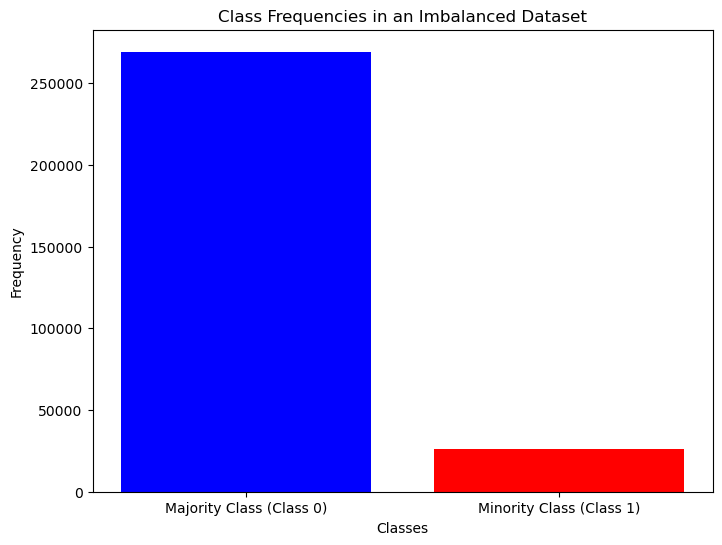

In [ ]:

# Count the frequencies of each class
class_counts = [len(data_copy['y_train'][data_copy['y_train'] == 0]), len(data_copy['y_train'][data_copy['y_train'] == 1])]

print(f"Ratio of majority class to minority class: {class_counts[0] / class_counts[1]:.2f}")

# Plot the class frequencies using a bar chart
plt.figure(figsize=(8, 6))
plt.bar(['Majority Class (Class 0)', 'Minority Class (Class 1)'], class_counts, color=['blue', 'red'])
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.title('Class Frequencies in an Imbalanced Dataset')
plt.show()

# Model Selection and Hyperparameters tuning

## Learning Rate Selection in Logistic Regression

Crossvalidation to find best learning rate

In [ ]:
max_iter = 1000

In [ ]:
# Using the generic cross-validation function
def learning_function(y, tx, gamma):
    initial_w = np.zeros(tx.shape[1])
    return logistic_regression(y, tx, initial_w, max_iters=1000, gamma=gamma)

gammas = [0.1, 0.2, 0.4, 0.6, 0.8]

best_gamma, results = cross_validate_hyperparameter(data_copy['y_train'], data_copy['x_train'], learning_function, gammas)

Param=0.1 | Mean F1=0.4153
Param=0.2 | Mean F1=0.4204
Param=0.4 | Mean F1=0.4239
Param=0.6 | Mean F1=0.4255
Param=0.8 | Mean F1=0.4267

✅ Best param: 0.8 (F1=0.4267)


From the crossvalidation gamma as 0.8 gets the higher F1 score but by comparing the training loss we chose gamma as 0.5 being the maximum gamma for which we don't have oscillations.

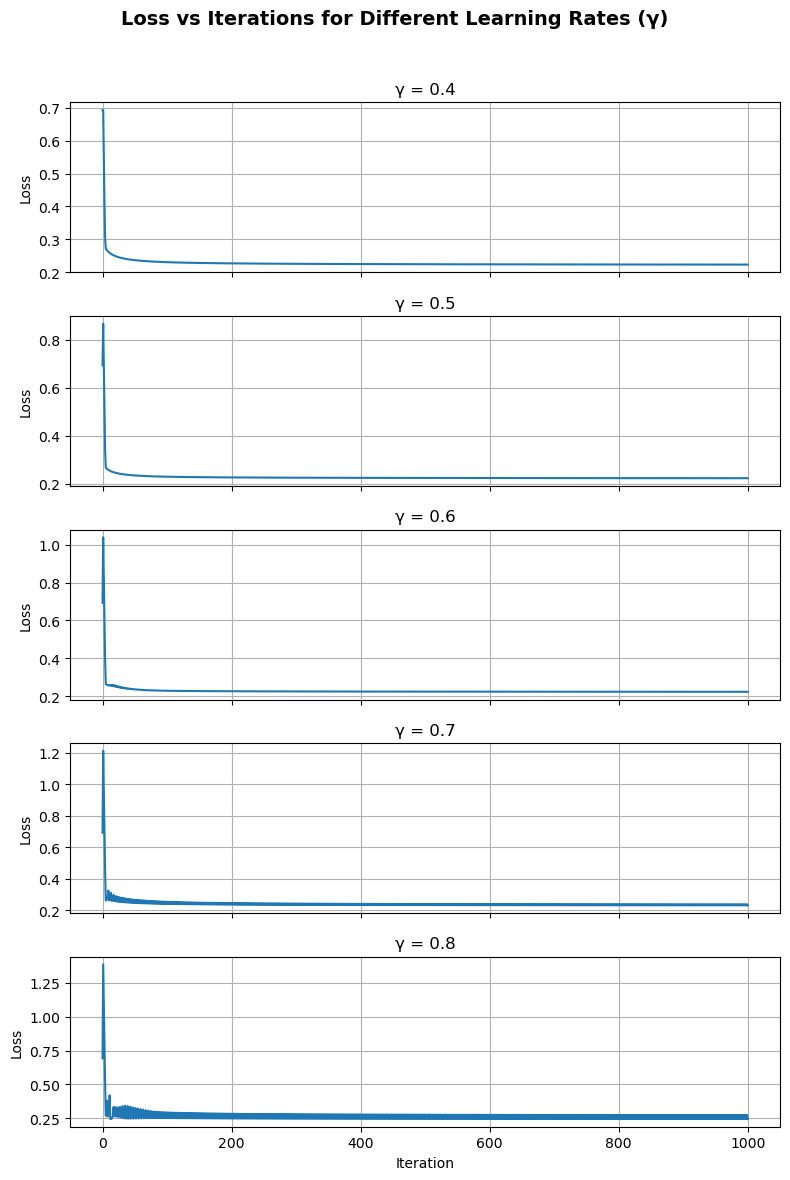

In [ ]:
best_gamma = 0.5

✅ Best threshold: 0.36 | F1_val = 0.427 | Acc_val = 0.873


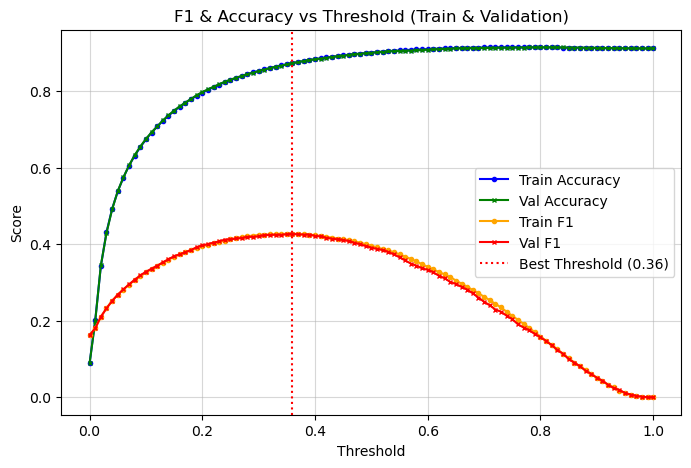

In [ ]:
# Train final model with best gamma and get training history
weights, losses = logistic_regression(data_copy['y_train'], data_copy['x_train'], np.zeros(data_copy['x_train'].shape[1]), max_iters=max_iter, gamma=best_gamma, return_history=True)
# Plot training and validation performance
best_t = plot_training_validation_performance(data_copy['x_train'], data_copy['y_train'], data_copy['x_val'], data_copy['y_val'], weights, losses)

plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss vs Iterations for logistic regression with gamma =", best_gamma)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#best_t = 0.36
# Predict on test set and create submission file
test_pred = predict_labels_logistic(data_copy['x_test'], weights[-1], threshold=best_t)
#Convert test_pred to 1 and -1
test_pred = np.where(test_pred == 1, 1, -1)
create_csv_submission(data_copy['test_ids'], test_pred, 'logistic_regression_submission.csv')

From AI crowd: 
- **F1-Score**: 0.437
- **Accuracy**: 0.877

## Lambda tuning in ridge logistic regression

In [ ]:
# Using the generic cross-validation function
def learning_function(y, tx, lambda_):
    initial_w = np.zeros(tx.shape[1])
    return reg_logistic_regression(y, tx, lambda_, initial_w, max_iters=max_iter, gamma=best_gamma)

lambdas = [1e-6, 1e-4, 1e-2, 1e-1]

best_lambda, results = cross_validate_hyperparameter(data_copy['y_train'], data_copy['x_train'], learning_function, lambdas)

Param=1e-06 | Mean F1=0.4267
Param=0.0001 | Mean F1=0.4263
Param=0.01 | Mean F1=0.4046
Param=0.1 | Mean F1=0.3093

✅ Best param: 1e-06 (F1=0.4267)


✅ Best threshold: 0.36 | F1_val = 0.427 | Acc_val = 0.873


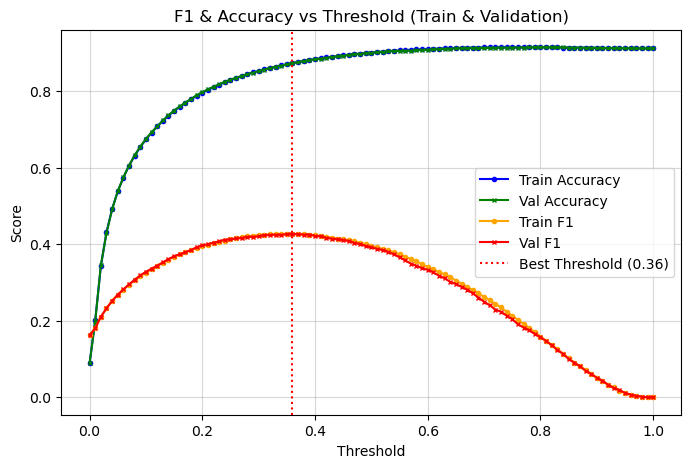

In [ ]:
# Train final model with best gamma and get training history
weights_1, losses_1 = reg_logistic_regression(data_copy['y_train'], data_copy['x_train'], best_lambda, np.zeros(data_copy['x_train'].shape[1]), max_iters=max_iter, gamma=best_gamma, return_history=True)
# Plot training and validation performance
best_t = plot_training_validation_performance(data_copy['x_train'], data_copy['y_train'], data_copy['x_val'], data_copy['y_val'], weights_1, losses_1)

plt.plot(losses_1)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss vs Iterations for regularized logistic regression with gamma =", best_gamma, "and lambda =", best_lambda)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#best_t = 0.36
# Predict on test set and create submission file
test_pred = predict_labels_logistic(data_copy['x_test'], weights_1[-1], threshold=best_t)
#Convert test_pred to 1 and -1
test_pred = np.where(test_pred == 1, 1, -1)
create_csv_submission(data_copy['test_ids'], test_pred, 'logistic_regression_submission.csv')

From AI crowd: 
- **F1-Score**: 0.437
- **Accuracy**: 0.877

## Polynomial Feature Expansion

In [ ]:
degrees = [2,3,4]
best_degree, results = cross_validate_degrees(data_copy['x_train'], data_copy['y_train'], degrees, data_copy['continuous'], k=5, max_iters=max_iter, gamma=best_gamma)

Degree=2 | Mean F1=0.4253
Degree=3 | Mean F1=0.4247
Degree=4 | Mean F1=0.4247

✅ Best degree: 2 (F1=0.4253)


✅ Best threshold: 0.38 | F1_val = 0.426 | Acc_val = 0.875


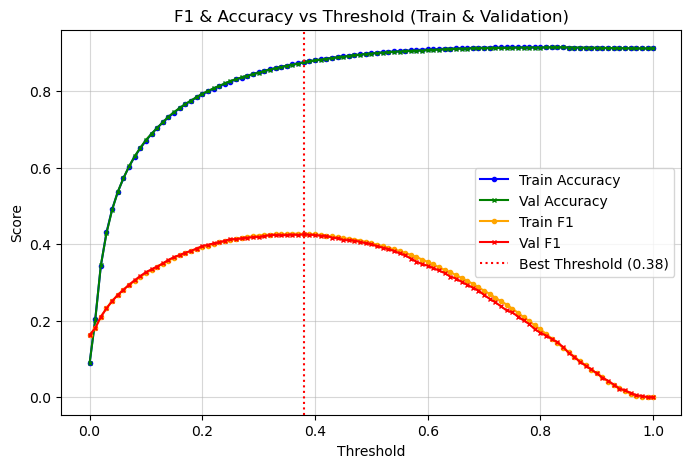

In [ ]:
x_train_poly = build_poly(data_copy['x_train'], best_degree, to_expand=data_copy['continuous'])
x_val_poly = build_poly(data_copy['x_val'], best_degree, to_expand=data_copy['continuous'])
x_test_poly = build_poly(data_copy['x_test'], best_degree, to_expand=data_copy['continuous'])

weights_2, losses_2 = logistic_regression(data_copy['y_train'], x_train_poly, np.zeros(x_train_poly.shape[1]), max_iters=max_iter, gamma=best_gamma, return_history=True)

best_t = plot_training_validation_performance(x_train_poly, data_copy['y_train'], x_val_poly, data_copy['y_val'], weights_2, losses_2)

plt.plot(losses_2)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss vs Iterations for logistic regression with polynomial feature expansion of degree =", best_degree)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#best_t = 0.38
# Predict on test set and create submission file
test_pred = predict_labels_logistic(x_test_poly, weights[-1]_2, threshold=best_t)
#Convert test_pred to 1 and -1
test_pred = np.where(test_pred == 1, 1, -1)
create_csv_submission(data_copy['test_ids'], test_pred, 'logistic_regression_submission.csv')

From AI crowd: 
- **F1-Score**: 0.437
- **Accuracy**: 0.878

## Weighted logistic regression

In [ ]:
# Using the generic cross-validation function
def learning_function(y, tx, relative_weight):
    initial_w = np.zeros(tx.shape[1])
    sample_weights = 1 + (relative_weight - 1) * y
    return weighted_reg_logistic_regression(y, tx, 0, sample_weights, initial_w, max_iters=max_iter, gamma=best_gamma)

relative_weights = [1, 4, 6, 10, 14]
best_relative_weight, results = cross_validate_hyperparameter(data_copy['y_train'], data_copy['x_train'], learning_function, relative_weights)

Param=1 | Mean F1=0.4267
Param=4 | Mean F1=0.4203
Param=6 | Mean F1=0.4152
Param=10 | Mean F1=0.3579
Param=14 | Mean F1=0.4227

✅ Best param: 1 (F1=0.4267)


✅ Best threshold: 0.36 | F1_val = 0.427 | Acc_val = 0.873


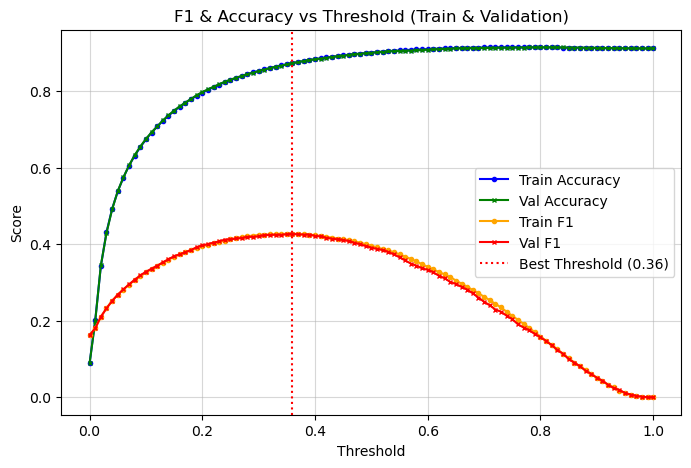

In [ ]:
sample_weights = 1 + (best_relative_weight - 1) * data_copy['y_train']
initial_w = np.zeros(data_copy['x_train'].shape[1])
weights_3, losses_3 = weighted_reg_logistic_regression(data_copy['y_train'], data_copy['x_train'], 0, sample_weights, initial_w, max_iter, best_gamma, return_history=True)

best_t = plot_training_validation_performance(data_copy['x_train'], data_copy['y_train'], data_copy['x_val'], data_copy['y_val'], weights_3, losses_3)

plt.plot(losses_3)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss vs Iterations for weighted logistic regression with relative weight  =", best_relative_weight)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#best_t = 0.36
# Predict on test set and create submission file
test_pred = predict_labels_logistic(data_copy['x_test'], weights[-1], threshold=best_t)
#Convert test_pred to 1 and -1
test_pred = np.where(test_pred == 1, 1, -1)
create_csv_submission(data_copy['test_ids'], test_pred, 'logistic_regression_submission.csv')

From AI crowd: 
- **F1-Score**: 0.437
- **Accuracy**: 0.877

## Oversample

In [ ]:
def learning_function(y, tx, oversampling_ratio):
    x_over, y_over = oversample_data(tx, y, ratio=oversampling_ratio)
    initial_w = np.zeros(x_over.shape[1])
    return logistic_regression(y_over, x_over, initial_w, max_iters=max_iter, gamma=best_gamma)

ratios = [0.2, 0.4, 0.6, 0.8]
best_ratio, results = cross_validate_hyperparameter(data_copy['y_train'], data_copy['x_train'], learning_function, ratios)

Param=0.2 | Mean F1=0.4253
Param=0.4 | Mean F1=0.4223
Param=0.6 | Mean F1=0.4059
Param=0.8 | Mean F1=0.3776

✅ Best param: 0.2 (F1=0.4253)


✅ Best threshold: 0.05 | F1_val = 0.424 | Acc_val = 0.867


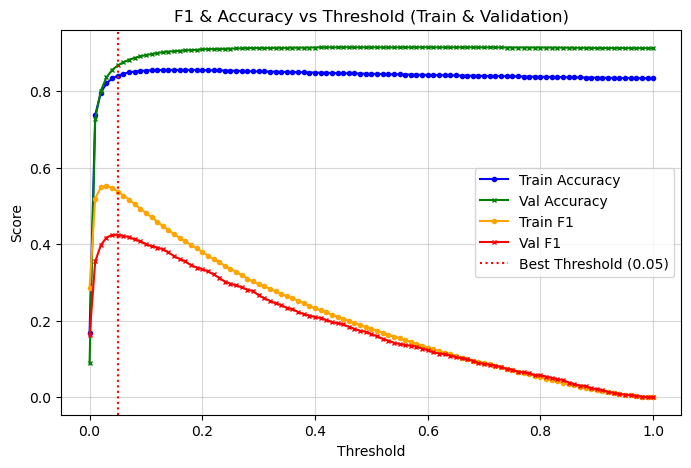

In [ ]:
x_over, y_over = oversample_data(data_copy['x_train'], data_copy['y_train'], ratio=best_ratio)
initial_w = np.zeros(x_over.shape[1])
weights_4, losses_4 =logistic_regression(y_over, x_over,initial_w, max_iter, best_gamma, return_history=True)

best_t = plot_training_validation_performance(x_over, y_over, data_copy['x_val'], data_copy['y_val'], weights_4, losses_4)

plt.plot(losses_4)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss vs Iterations for  logistic regression with oversampling with ratio =", best_ratio)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#best_t = 0.05
# Predict on test set and create submission file
test_pred = predict_labels_logistic(data_copy['x_test'], weights[-1]_4, threshold=best_t)
#Convert test_pred to 1 and -1
test_pred = np.where(test_pred == 1, 1, -1)
create_csv_submission(data_copy['test_ids'], test_pred, 'logistic_regression_submission.csv')

From AI crowd: 
- **F1-Score**: 0.436
- **Accuracy**: 0.870

Based on the different cross-validation the best results are obtained with logistic regression without regularization with feature polynomial expansion (degree = 2) with a learning rate of 0.8